# Load data

In [1]:
from pathlib import Path
import pickle
import numpy as np

feat_dir = "./features"
models_dir = "./models"

load_file = f"{feat_dir}/new_X_train.pkl"
with open(load_file, "rb") as load_file:
    X_train = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_y_train.pkl"
with open(load_file, "rb") as load_file:
    y_train = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_X_eval.pkl"
with open(load_file, "rb") as load_file:
    X_eval = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_y_eval.pkl"
with open(load_file, "rb") as load_file:
    y_eval = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_X_unbal.pkl"
with open(load_file, "rb") as load_file:
    X_unbal = pickle.load(load_file)
    
load_file = f"{feat_dir}/new_y_unbal.pkl"
with open(load_file, "rb") as load_file:
    y_unbal = pickle.load(load_file)

   ## Load labels

In [15]:
load_file = f"{feat_dir}/new_multiLabelBinarizer.pkl"
with open(load_file, "rb") as load_file:
    mlb = pickle.load(load_file)
    
#Load classes names
with open(f"{feat_dir}/new_classes_dict.pkl", "rb") as classes_file:
    classes_dict = pickle.load(classes_file)

# Create model

In [3]:
import keras
from keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation, Lambda
import keras.backend as K
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)

def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

time_steps = 10
freq_bins = 128
classes_num = 10

# Hyper parameters
hidden_units = 1024
drop_rate = 0.5
batch_size = 500

# Embedded layers
input_layer = Input(shape=X[0].shape)

a1 = Dense(hidden_units)(input_layer)
a1 = BatchNormalization()(a1)
a1 = Activation('relu')(a1)
a1 = Dropout(drop_rate)(a1)

a2 = Dense(hidden_units)(a1)
a2 = BatchNormalization()(a2)
a2 = Activation('relu')(a2)
a2 = Dropout(drop_rate)(a2)

a3 = Dense(hidden_units)(a2)
a3 = BatchNormalization()(a3)
a3 = Activation('relu')(a3)
a3 = Dropout(drop_rate)(a3)
cla = Dense(hidden_units, activation='linear')(a3)
att = Dense(hidden_units, activation='sigmoid')(a3)

b1 = Lambda(attention_pooling, output_shape=pooling_shape)([cla, att])
b1 = BatchNormalization()(b1)
b1 = Activation(activation='relu')(b1)
b1 = Dropout(drop_rate)(b1)

output_layer = Dense(classes_num, activation='sigmoid')(b1)

model = keras.Model(inputs=input_layer, outputs=output_layer, name="qiuqiangkong")
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "qiuqiangkong"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 128)]    0           []                               
                                                                                                  
 dense (Dense)                  (None, 10, 1024)     132096      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 1024)    4096        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 10, 1024)     0           ['batch_normalization[

## Train the model only with balanced data

In [4]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


history = model.fit(
    X_train,
    y_train,
    batch_size=64, # batch size 1 doesn't work
    epochs=100,
    validation_data=(X_eval, y_eval),
    callbacks =[earlystopping]
)

Epoch 1/100
105/105 [==============================] - 19s 116ms/step - loss: 0.1170 - accuracy: 0.8457 - val_loss: 0.0945 - val_accuracy: 0.8775
Epoch 2/100
105/105 [==============================] - 9s 83ms/step - loss: 0.0653 - accuracy: 0.8939 - val_loss: 0.0708 - val_accuracy: 0.9011
Epoch 3/100
105/105 [==============================] - 8s 81ms/step - loss: 0.0541 - accuracy: 0.9096 - val_loss: 0.0841 - val_accuracy: 0.9028
Epoch 4/100
105/105 [==============================] - 10s 91ms/step - loss: 0.0488 - accuracy: 0.9199 - val_loss: 0.0714 - val_accuracy: 0.9051
Epoch 5/100
105/105 [==============================] - 10s 97ms/step - loss: 0.0445 - accuracy: 0.9262 - val_loss: 0.0759 - val_accuracy: 0.9041
Epoch 6/100
105/105 [==============================] - 17s 160ms/step - loss: 0.0396 - accuracy: 0.9310 - val_loss: 0.0723 - val_accuracy: 0.9021
Epoch 7/100
105/105 [==============================] - 12s 115ms/step - loss: 0.0351 - accuracy: 0.9358 - val_loss: 0.1193 - val_a

In [7]:
model.save(f"{models_dir}/new_qiuqiangkong_b64_bal.tf")

INFO:tensorflow:Assets written to: ./models/new_qiuqiangkong_b64_bal.tf\assets


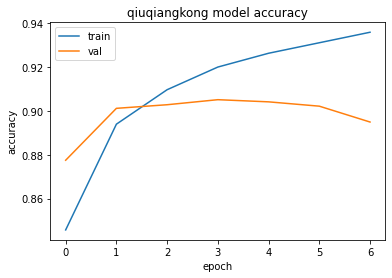

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('qiuqiangkong model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

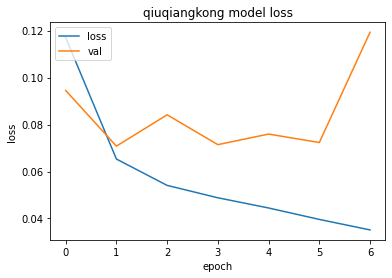

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('qiuqiangkong model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

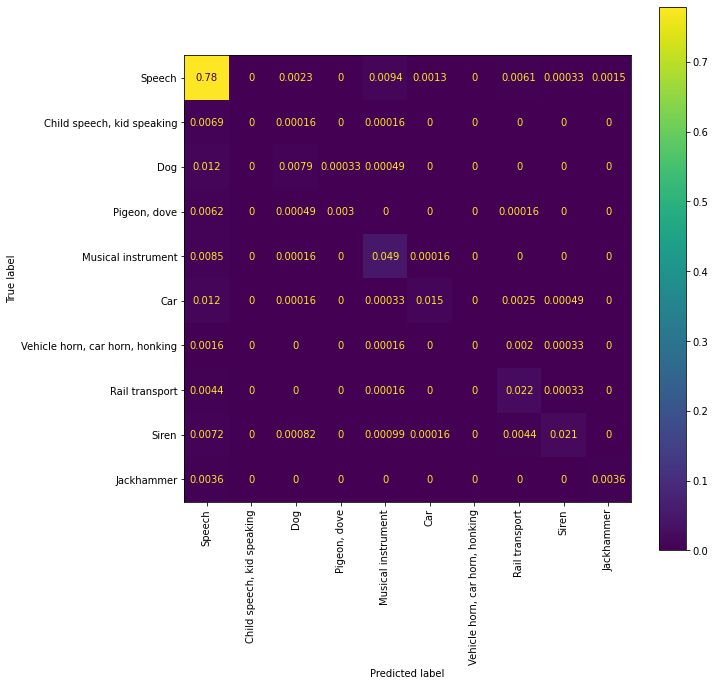

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = model.predict(X_eval)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)
y_eval_transformed = np.argmax(y_eval, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_eval_transformed, y_pred, normalize="all",
                                              display_labels=[classes_dict.get(y) for y in mlb.classes_],
                                               xticks_rotation='vertical', ax=ax)

## Training with balanced and unbalanced data

In [ ]:
X = np.concatenate((X_train, X_unbal))
y = np.concatenate((y_train, y_unbal))

In [17]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)


history2 = model.fit(
    X,
    y,
    batch_size=128, # batch size 1 doesn't work
    epochs=100,
    validation_data=(X_eval, y_eval),
    callbacks =[earlystopping]
)

Epoch 1/100
8737/8737 [==============================] - 2539s 291ms/step - loss: 0.0266 - accuracy: 0.9542 - val_loss: 0.0509 - val_accuracy: 0.9194
Epoch 2/100
8737/8737 [==============================] - 2652s 304ms/step - loss: 0.0241 - accuracy: 0.9584 - val_loss: 0.0527 - val_accuracy: 0.9174
Epoch 3/100
8737/8737 [==============================] - 2527s 289ms/step - loss: 0.0232 - accuracy: 0.9600 - val_loss: 0.0490 - val_accuracy: 0.9203
Epoch 4/100
8737/8737 [==============================] - 2539s 291ms/step - loss: 0.0226 - accuracy: 0.9611 - val_loss: 0.0469 - val_accuracy: 0.9231
Epoch 5/100
8737/8737 [==============================] - 2448s 280ms/step - loss: 0.0222 - accuracy: 0.9616 - val_loss: 0.0476 - val_accuracy: 0.9208
Epoch 6/100
8737/8737 [==============================] - 2490s 285ms/step - loss: 0.0219 - accuracy: 0.9619 - val_loss: 0.0446 - val_accuracy: 0.9241
Epoch 7/100
8737/8737 [==============================] - 2438s 279ms/step - loss: 0.0216 - accuracy:

In [18]:
model.save(f"{models_dir}/new_qiuqiangkong_b128_all.tf")

INFO:tensorflow:Assets written to: ./models/new_qiuqiangkong_b128_all.tf\assets


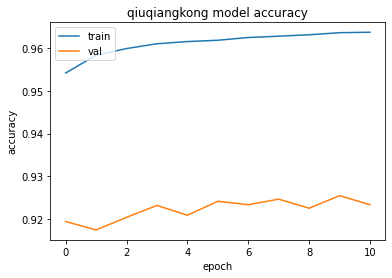

In [19]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('qiuqiangkong model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

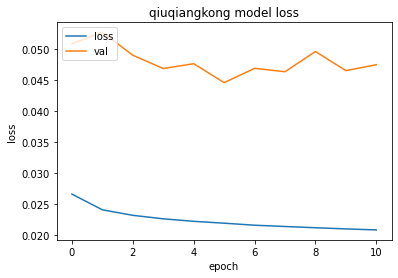

In [20]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('qiuqiangkong model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

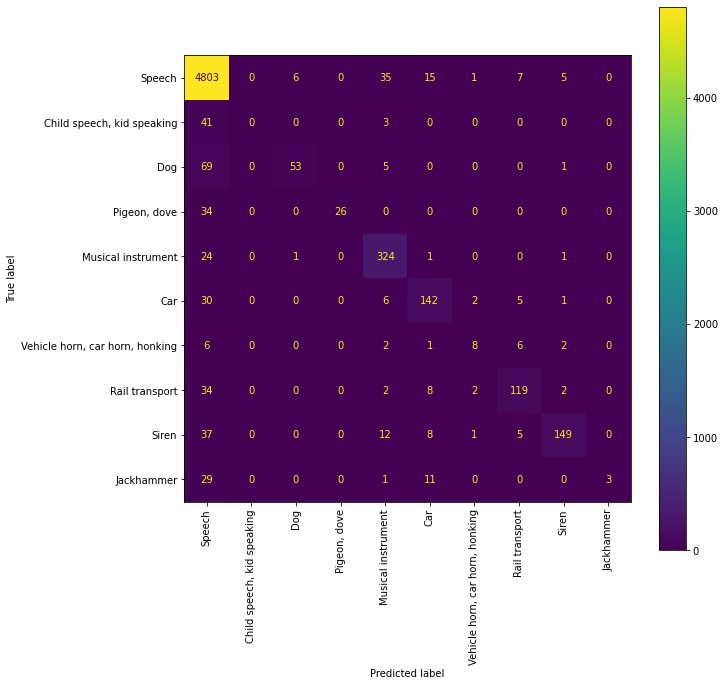

In [22]:
# Generate predictions
y_pred = model.predict(X_eval)

# Transform one hot encoding to a series of ints for confusion matrix
y_pred = np.argmax(y_pred, axis=1)
y_eval_transformed = np.argmax(y_eval, axis=1)

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_eval_transformed, y_pred,
                                              display_labels=[classes_dict.get(y) for y in mlb.classes_],
                                               xticks_rotation='vertical', ax=ax)